# Detección de transacciones fraudulentas en sistema bancario

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#importing packages for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#Importando nuestra data
df = pd.read_csv("./creditcard.csv")
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#Para la detección de fraude no veo relevante el uso de la variable tiempo, por lo que la eliminamos
df = df.drop("Time", axis=1)
#vamos a utilizar preprocessing de sklearn, que nos puede ayudar a mejorar la calidad de la data
from sklearn import preprocessing
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
scaler = preprocessing.StandardScaler()
undersample = RandomUnderSampler(sampling_strategy=0.5)



In [4]:
#standard scaling al monto, debido a que estos pueden ser desde 0.01 centavo hasta montos mayores a 1,000 y de distintas monedas
df['std_Amount'] = scaler.fit_transform(df['Amount'].values.reshape (-1,1))
#Quitamos variable Monto, ya que tenemos sst_amount
df = df.drop("Amount", axis=1)

In [5]:
#vamos a dividir el dataset, la class es nuestra variable objetivo
cols = df.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

In [6]:
#Definiendo x y y, X son todas las columnas y Y es nuestro target
X = df[cols]
Y = df[target]
#undersample, debido al imbalance de la data, ya que el fraude vs transacciones normales es muy grande la diferencia.
X_under, Y_under = undersample.fit_resample(X, Y)

In [7]:
test = pd.DataFrame(Y_under, columns = ['Class'])

In [8]:
#Vamos a dividir nuestra data en train y test
X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=1)

# Set de pruebas 1:

### Se utilizó sklearn solo para comparar como se comporta el análisis respecto a Keras

## Prueba MLP Classifier con LBFGS

In [29]:
model5 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100,100), random_state=2)
mlp = model5.fit(X_train, y_train)

In [30]:
model5.get_params(deep=True)

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100, 100),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 2,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [31]:
#Predicciones del modelo
y_pred_mlp = model5.predict(X_test)

### Resultados:

In [32]:
#scores
print("Accuracy MLP:",metrics.accuracy_score(y_test, y_pred_mlp))
print("Precision MLP:",metrics.precision_score(y_test, y_pred_mlp))
print("Recall MLP:",metrics.recall_score(y_test, y_pred_mlp))
print("F1 Score MLP:",metrics.f1_score(y_test, y_pred_mlp))

Accuracy MLP: 0.9527027027027027
Precision MLP: 0.9272727272727272
Recall MLP: 0.9444444444444444
F1 Score MLP: 0.9357798165137615


In [33]:
#Estimado de probabilidad
y_pred_mlp_proba = model5.predict_proba(X_test)[::,1]
fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test,  y_pred_mlp_proba)
auc_mlp = metrics.roc_auc_score(y_test, y_pred_mlp_proba)
print("AUC MLP :", auc_mlp)

AUC MLP : 0.9775167454688731


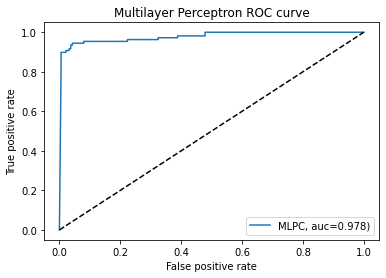

In [34]:
#ROC
plt.plot(fpr_mlp,tpr_mlp,label="MLPC, auc={:.3f})".format(auc_mlp))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Multilayer Perceptron ROC curve')
plt.legend(loc=4)
plt.show()



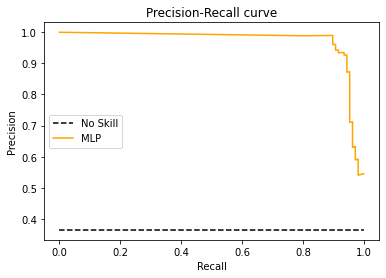

In [35]:
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, y_pred_mlp_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(mlp_recall, mlp_precision, color='orange', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

## Prueba MLP Classifier con SDG

In [61]:
model6 = MLPClassifier(solver='sgd', hidden_layer_sizes=(100,100), random_state=2)
mlp = model6.fit(X_train, y_train)
model6.get_params(deep=True)
#Predicciones del modelo
y_pred_mlp6 = model6.predict(X_test)
#scores
print("Accuracy MLP:",metrics.accuracy_score(y_test, y_pred_mlp6))
print("Precision MLP:",metrics.precision_score(y_test, y_pred_mlp6))
print("Recall MLP:",metrics.recall_score(y_test, y_pred_mlp6))
print("F1 Score MLP:",metrics.f1_score(y_test, y_pred_mlp6))

Accuracy MLP: 0.9391891891891891
Precision MLP: 0.9411764705882353
Recall MLP: 0.8888888888888888
F1 Score MLP: 0.9142857142857143


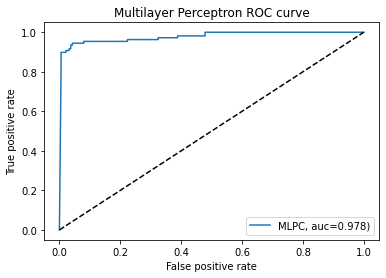

In [62]:
#ROC
plt.plot(fpr_mlp,tpr_mlp,label="MLPC, auc={:.3f})".format(auc_mlp))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Multilayer Perceptron ROC curve')
plt.legend(loc=4)
plt.show()

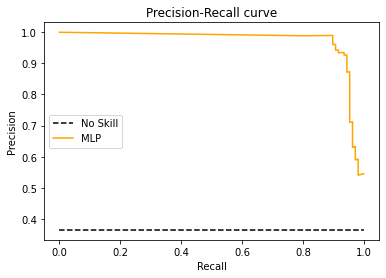

In [63]:
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, y_pred_mlp_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(mlp_recall, mlp_precision, color='orange', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

## Prueba MLP Classifier con ADAM

In [66]:
model7 = MLPClassifier(solver='adam', hidden_layer_sizes=(100,100), random_state=2)
mlp = model7.fit(X_train, y_train)
model7.get_params(deep=True)
#Predicciones del modelo
y_pred_mlp7 = model7.predict(X_test)
#scores
print("Accuracy MLP:",metrics.accuracy_score(y_test, y_pred_mlp7))
print("Precision MLP:",metrics.precision_score(y_test, y_pred_mlp7))
print("Recall MLP:",metrics.recall_score(y_test, y_pred_mlp7))
print("F1 Score MLP:",metrics.f1_score(y_test, y_pred_mlp7))

Accuracy MLP: 0.9425675675675675
Precision MLP: 0.9252336448598131
Recall MLP: 0.9166666666666666
F1 Score MLP: 0.9209302325581395


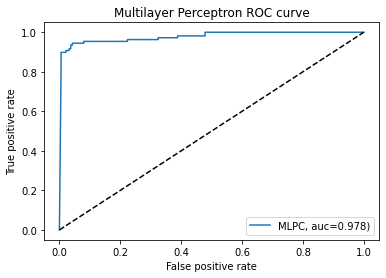

In [67]:
#ROC
plt.plot(fpr_mlp,tpr_mlp,label="MLPC, auc={:.3f})".format(auc_mlp))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Multilayer Perceptron ROC curve')
plt.legend(loc=4)
plt.show()

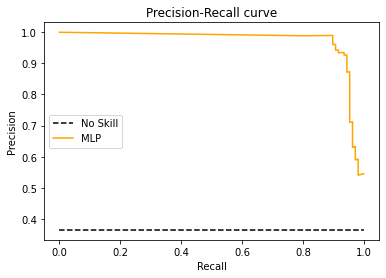

In [68]:
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, y_pred_mlp_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(mlp_recall, mlp_precision, color='orange', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# Opcion 2 MLP con Tensorflow y Keras

In [9]:
#train the model
model = Sequential()
model.add(Dense(64, input_shape=(29,), activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(32, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(16, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(8, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(4, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(1, activation='sigmoid'))

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer

model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy',tf.keras.metrics.SensitivityAtSpecificity(0.5)]) #metrics

In [29]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1,mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(X_train.values, y_train.values, epochs = 6, batch_size=5, validation_split = 0.15, verbose = 0,
                    callbacks = [earlystopper])
history_ker = history.history


Text(0.5, 0, 'Epochs')

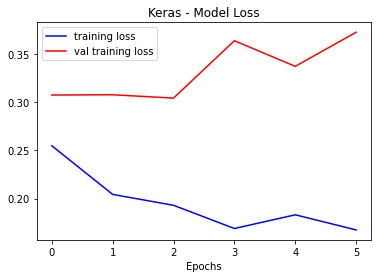

In [30]:
loss_values = history_ker['loss']
val_loss_values=history_ker['val_loss']
plt.title('Keras - Model Loss')
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

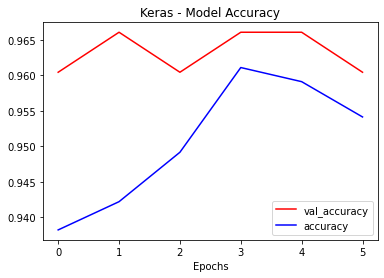

In [31]:


accuracy_values = history_ker['accuracy']
val_accuracy_values=history_ker['val_accuracy']
plt.title('Keras - Model Accuracy')
plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()
plt.xlabel("Epochs")



In [33]:
history_ker

{'loss': [0.25483250617980957,
  0.2042810022830963,
  0.19296908378601074,
  0.16886086761951447,
  0.18309004604816437,
  0.16739016771316528],
 'accuracy': [0.938185453414917,
  0.9421734809875488,
  0.9491525292396545,
  0.9611166715621948,
  0.9591226577758789,
  0.9541375637054443],
 'sensitivity_at_specificity': [0.981249988079071,
  0.996874988079071,
  0.9937499761581421,
  1.0,
  0.996874988079071,
  0.996874988079071],
 'val_loss': [0.3075242042541504,
  0.3078111708164215,
  0.30435600876808167,
  0.3639579713344574,
  0.33735203742980957,
  0.37276726961135864],
 'val_accuracy': [0.9604519605636597,
  0.9661017060279846,
  0.9604519605636597,
  0.9661017060279846,
  0.9661017060279846,
  0.9604519605636597],
 'val_sensitivity_at_specificity': [0.96875,
  0.96875,
  0.96875,
  0.953125,
  0.953125,
  0.9375]}

In [18]:
y_pred_nn = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [19]:
#AUC
y_pred_nn_proba = model.predict_proba(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred_nn_proba)
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC Neural Net: ', auc_keras)



Instructions for updating:
Please use `model.predict()` instead.
AUC Neural Net:  0.9773689913317571


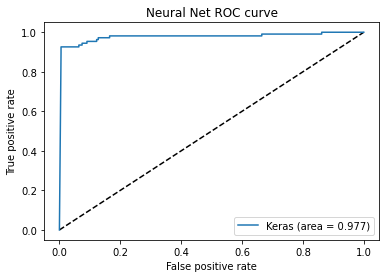

In [20]:
#ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Neural Net ROC curve')
plt.legend(loc='best')
plt.show()

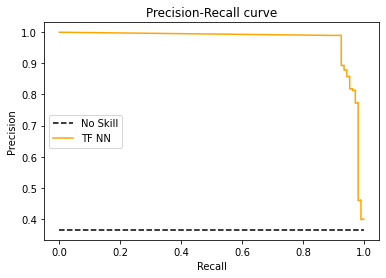

In [21]:
nn_precision, nn_recall, _ = precision_recall_curve(y_test, y_pred_nn_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(nn_recall, nn_precision, color='orange', label='TF NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()